# Classifying Images with CNNs

In this exercise you will design a Convolutional Neural Network (CNN) for MNIST. CNNs are the workhorses of modern computer vision.

In [1]:
import numpy as np

from sklearn.metrics import accuracy_score

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, Flatten, Activation, Dense, Dropout
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

# CNN

Let's build a convolutional model! For this, we need to have the data in its original shape. Also note that when we reshape the data below, we add a dimension of 1 - this is the number of **channels** in the image, which is just 1 because these are grayscale images. If they were color, this would be 3 for RGB. Make sure you understand how and why we are preparing the data below.

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape)

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

(60000, 28, 28, 1)


## LeNet-5

Here is my attempt to replicate the LeNet-5 model as closely as possibly the original paper: Yann LeCun, Léon Bottou, Yoshua Bengio, and Patrick Haffner ["Gradient-based learning applied to document recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf).

As few modern neural network libraries allow for partially connected convolution layers, I've substituted this with a dropout layer. I've also replaced Hessian approximated momentum SGD with Adam optimizer.

In [4]:
model = Sequential()

model.add(Convolution2D(filters=6, 
                        kernel_size=(5, 5), 
                        padding="valid", 
                        input_shape = (28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation("sigmoid"))

model.add(Convolution2D(filters=16, 
                        kernel_size=(5, 5), 
                        padding="valid"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation("sigmoid"))
model.add(Dropout(0.5))

model.add(Convolution2D(filters=120, 
                        kernel_size=(1, 1), 
                        padding="valid"))

model.add(Flatten())
model.add(Dense(84))
model.add(Activation("sigmoid"))
model.add(Dense(10))
model.add(Activation('softmax'))

Training

In [5]:
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
hist = model.fit(X_train, y_train, 
                 batch_size=32, epochs=20, 
                 validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 10s - loss: 0.7510 - acc: 0.7497 - val_loss: 0.1899 - val_acc: 0.9420
Epoch 2/20
60000/60000 [==============================] - 9s - loss: 0.2413 - acc: 0.9246 - val_loss: 0.1283 - val_acc: 0.9609
Epoch 3/20
60000/60000 [==============================] - 9s - loss: 0.1938 - acc: 0.9385 - val_loss: 0.1011 - val_acc: 0.9679
Epoch 4/20
60000/60000 [==============================] - 9s - loss: 0.1657 - acc: 0.9474 - val_loss: 0.0932 - val_acc: 0.9690
Epoch 5/20
60000/60000 [==============================] - 9s - loss: 0.1479 - acc: 0.9534 - val_loss: 0.0811 - val_acc: 0.9740
Epoch 6/20
60000/60000 [==============================] - 8s - loss: 0.1390 - acc: 0.9565 - val_loss: 0.0702 - val_acc: 0.9775
Epoch 7/20
60000/60000 [==============================] - 9s - loss: 0.1276 - acc: 0.9589 - val_loss: 0.0659 - val_acc: 0.9794
Epoch 8/20
60000/60000 [==============================] - 9s

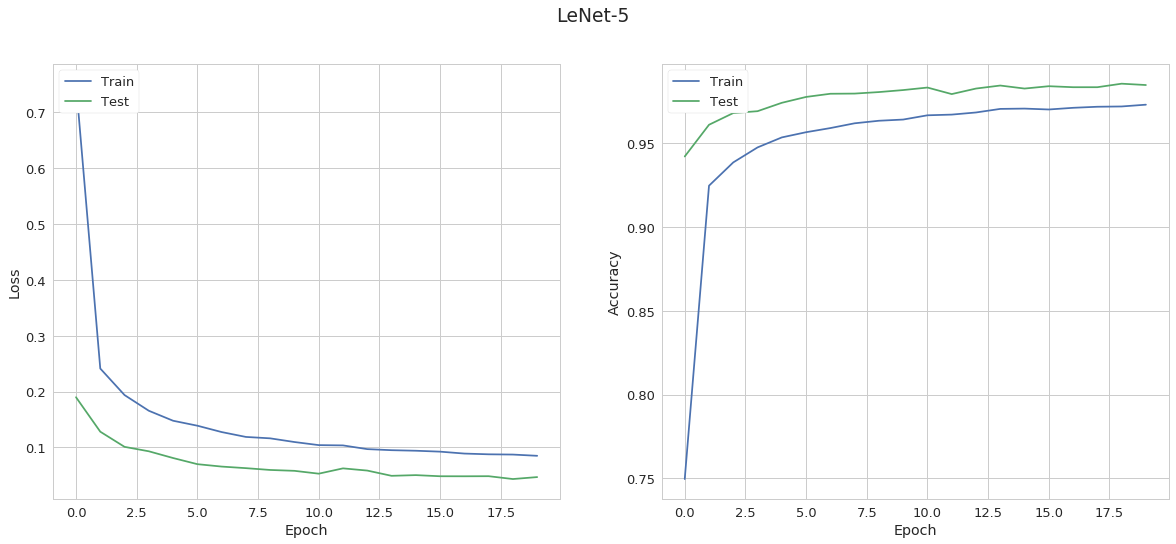

In [6]:
plt.figure(figsize=(20, 8))
plt.suptitle("LeNet-5")

plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Test")
plt.legend(frameon="True", loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(122)
plt.plot(hist.history["acc"], label="Train")
plt.plot(hist.history["val_acc"], label="Test")
plt.legend(frameon="True", loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy");

Let's make predictions for test data

In [7]:
preds_train = model.predict_classes(X_train)
preds_test = model.predict_classes(X_test)

 8992/10000 [=========================>....] - ETA: 0s

And once again, let's look at the misclassified examples.

True clases are shown with blue color and predictions are painted in red.

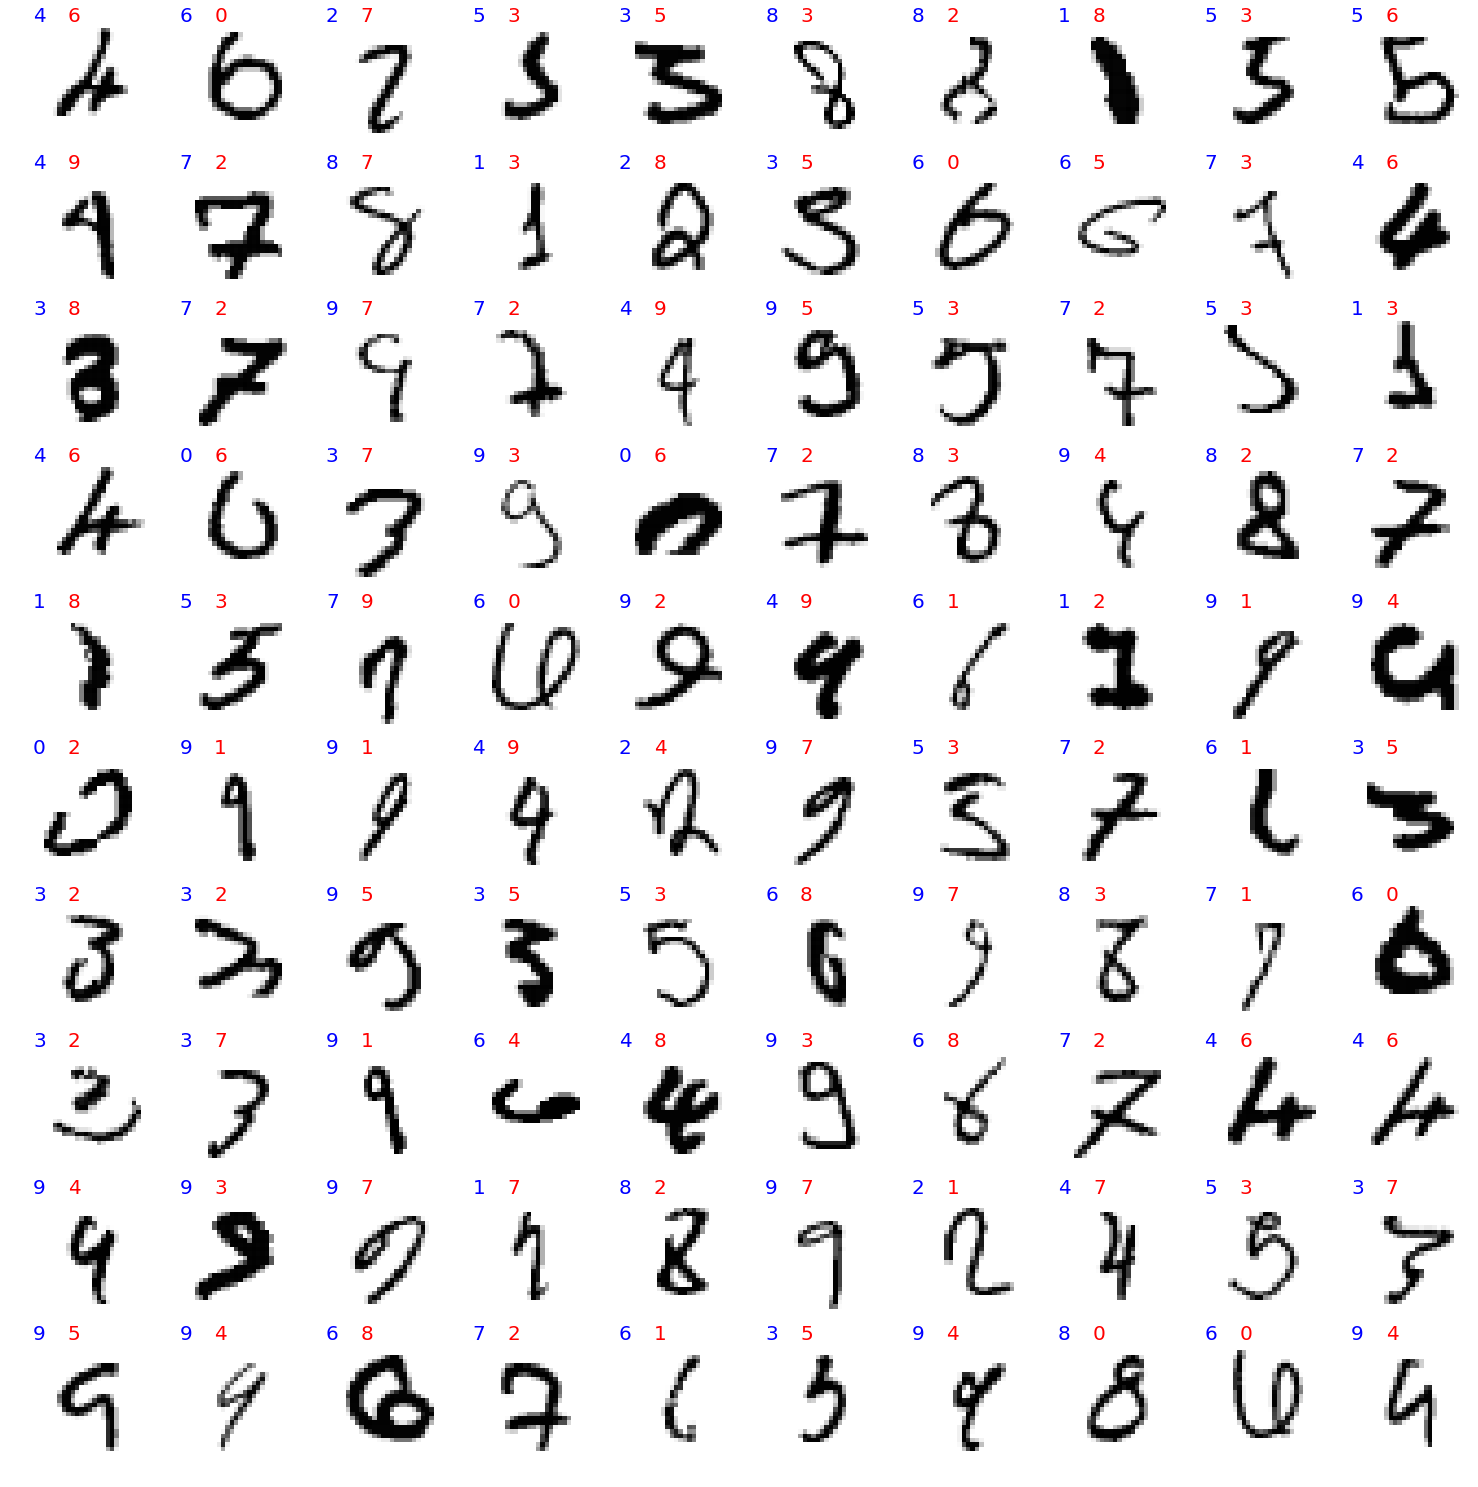

In [9]:
test_wrong = [im for im in zip(X_test, preds_test, np.argmax(y_test, axis=1)) if im[1] != im[2]]

plt.figure(figsize=(20, 20))
for ind, val in enumerate(test_wrong[:100]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.subplot(10, 10, ind + 1)
    im = 1 - val[0].reshape((28,28))
    plt.axis("off")
    plt.text(0, 0, val[2], fontsize=20, color="blue")
    plt.text(8, 0, val[1], fontsize=20, color="red")
    plt.imshow(im, cmap="gray")

### TASK 1

In [ ]:
print("Test accuracy {:.4f}".format(accuracy_score(np.argmax(y_train, axis=1), preds_train)))
print("Test accuracy {:.4f}".format(accuracy_score(np.argmax(y_test, axis=1), preds_test)))

## LeNet-5 with Data augmentation

The LeNet paper also introduced the idea of adding tweaks to the input data set in order to artificially increase the trainin set size. They suggested slightly distorting the image by shifting or stretching the pixels. The idea is that these distortions should not change the output image classification. Keras has a pre-built library for doing this (we have already used it in `DogsAndCats` notebook).

Let us try to use it here to improve the classification rate. Note that we do not want to flip the image, as this would change the meaning of some digits (6 & 9, for example). Minor rotations are okay, however.

In [10]:
# this will do preprocessing and realtime data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,             # set input mean to 0 over the dataset
    samplewise_center=False,              # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,   # divide each input by its std
    zca_whitening=False,                  # apply ZCA whitening
    rotation_range=25,                    # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,                # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,               # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,                # randomly flip images horizontally
    vertical_flip=False                   # randomly flip images vertically
)

We'll use the same adaptation of LeNet-5 architecture.

In [11]:
model = Sequential()

model.add(Convolution2D(filters=6, 
                        kernel_size=(5, 5), 
                        padding="valid", 
                        input_shape = (28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation("sigmoid"))

model.add(Convolution2D(filters=16, 
                        kernel_size=(5, 5), 
                        padding="valid"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation("sigmoid"))
model.add(Dropout(0.5))

model.add(Convolution2D(filters=120, 
                        kernel_size=(1, 1), 
                        padding="valid"))

model.add(Flatten())
model.add(Dense(84))
model.add(Activation("sigmoid"))
model.add(Dense(10))
model.add(Activation('softmax'))

Now we'll fit the model. Notice that the format for this is slightly different as the data is coming from `datagen.flow` rather than a single numpy array.

In [12]:
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
hist = model.fit_generator(datagen.flow(X_train, y_train), 
                           steps_per_epoch=int(np.ceil(len(X_train) / 32)), 
                           epochs=25, 
                           validation_data=(ImageDataGenerator().flow(X_test, y_test)), 
                           validation_steps = int(np.ceil(len(X_test) / 32)))

Epoch 1/25
1875/1875 [==============================] - 8s - loss: 1.2395 - acc: 0.5758 - val_loss: 0.2854 - val_acc: 0.9256
Epoch 2/25
1875/1875 [==============================] - 9s - loss: 0.5587 - acc: 0.8281 - val_loss: 0.1530 - val_acc: 0.9590
Epoch 3/25
1875/1875 [==============================] - 8s - loss: 0.4202 - acc: 0.8704 - val_loss: 0.1144 - val_acc: 0.9661
Epoch 4/25
1875/1875 [==============================] - 8s - loss: 0.3640 - acc: 0.8863 - val_loss: 0.1121 - val_acc: 0.9671
Epoch 5/25
1875/1875 [==============================] - 8s - loss: 0.3214 - acc: 0.9002 - val_loss: 0.0944 - val_acc: 0.9711
Epoch 6/25
1875/1875 [==============================] - 8s - loss: 0.2936 - acc: 0.9090 - val_loss: 0.0782 - val_acc: 0.9759
Epoch 7/25
1875/1875 [==============================] - 8s - loss: 0.2771 - acc: 0.9131 - val_loss: 0.0711 - val_acc: 0.9780
Epoch 8/25
1875/1875 [==============================] - 8s - loss: 0.2591 - acc: 0.9206 - val_loss: 0.0773 - val_acc: 0.9771


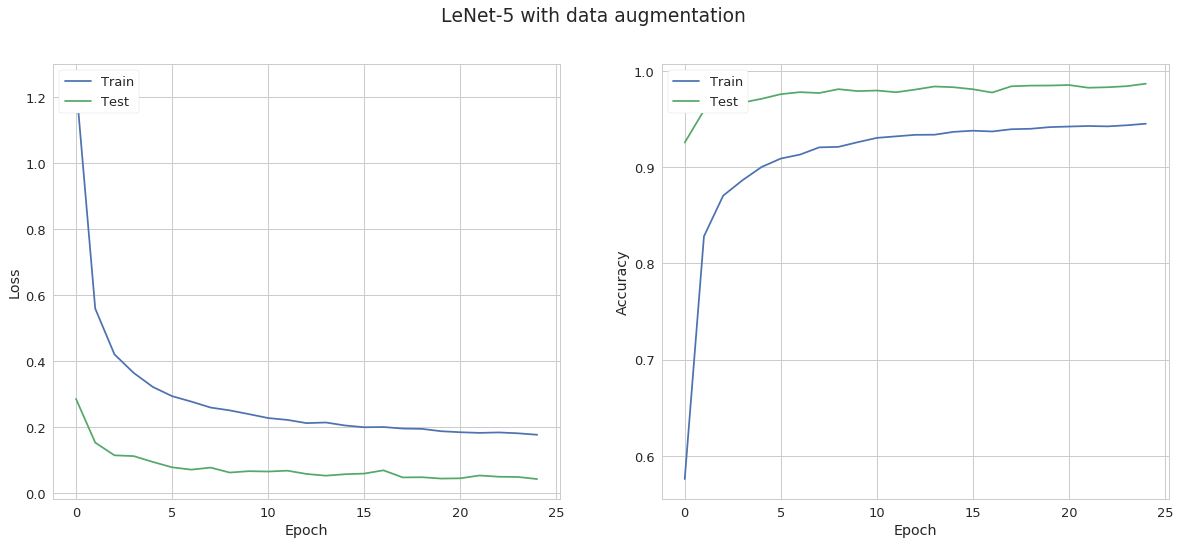

In [13]:
plt.figure(figsize=(20, 8))
plt.suptitle("LeNet-5 with data augmentation")

plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Test")
plt.legend(frameon="True", loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(122)
plt.plot(hist.history["acc"], label="Train")
plt.plot(hist.history["val_acc"], label="Test")
plt.legend(frameon="True", loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy");

Let's make predictions for test data

In [14]:
preds_train = model.predict_classes(X_train)
preds_test = model.predict_classes(X_test)

 9600/10000 [===========================>..] - ETA: 0s

In [15]:
print("Test accuracy {:.4f}".format(accuracy_score(np.argmax(y_train, axis=1), preds_train)))
print("Test accuracy {:.4f}".format(accuracy_score(np.argmax(y_test, axis=1), preds_test)))

Test accuracy 0.9839
Test accuracy 0.9859


How does the performance stack up? Not quite as good as the non-distorted version, though notice how the classifier does not overfit the same was as it would without the data augmentation.

At any rate, the true advantage of data augmentation comes when we have large models (regularization) or more complex learning tasks (generalization).

## TASK 2 - design a CNN for MNIST

It is up to you what the model will be. Here are some things you need to decide:
* how many convolutional layers?
* what spatial size will your convolutions be?
* how many channels will your convolutions be?
* what nonlinearity will you use?
* will you use pooling? what type?
* how many fully-connected layers will you have?
* will you use dropout?
* what batch size?

Keras provides a special layer called `Flatten` to flatten the convolutional features into a vector before the fully-connected layers. You should look at the documentation for Keras's convolutional layers: http://keras.io/layers/convolutional/. In particular, you may want to look at `Convolution2D`, `MaxPooling2D`, `AveragePooling2D`, `Flatten`, and `Dropout`. For this problem, you make want to use the `'rmsprop'` optimizer - it is an algorithm that adapts the learning rate during learning for you automatically.

Can you get to 98% accuracy? You shouldn't need more than a few epochs to do pretty well.

Suggestions:
* Try using at least 2 convolutional layers. This should get you off to a good start and it will come in handy later.

In [ ]:
model = Sequential()

# Design a CNN

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Fit your model

In [ ]:
score = model.evaluate(X_test, y_test, verbose=2)
print("Test score:", score[0])
print("Test accuracy:", score[1])